In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('weather.csv')
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [3]:
df = df.drop(['date'], axis = 1)
df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  1461 non-null   float64
 1   temp_max       1461 non-null   float64
 2   temp_min       1461 non-null   float64
 3   wind           1461 non-null   float64
 4   weather        1461 non-null   object 
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [5]:
df.shape

(1461, 5)

## Trực quan hóa dữ liệu

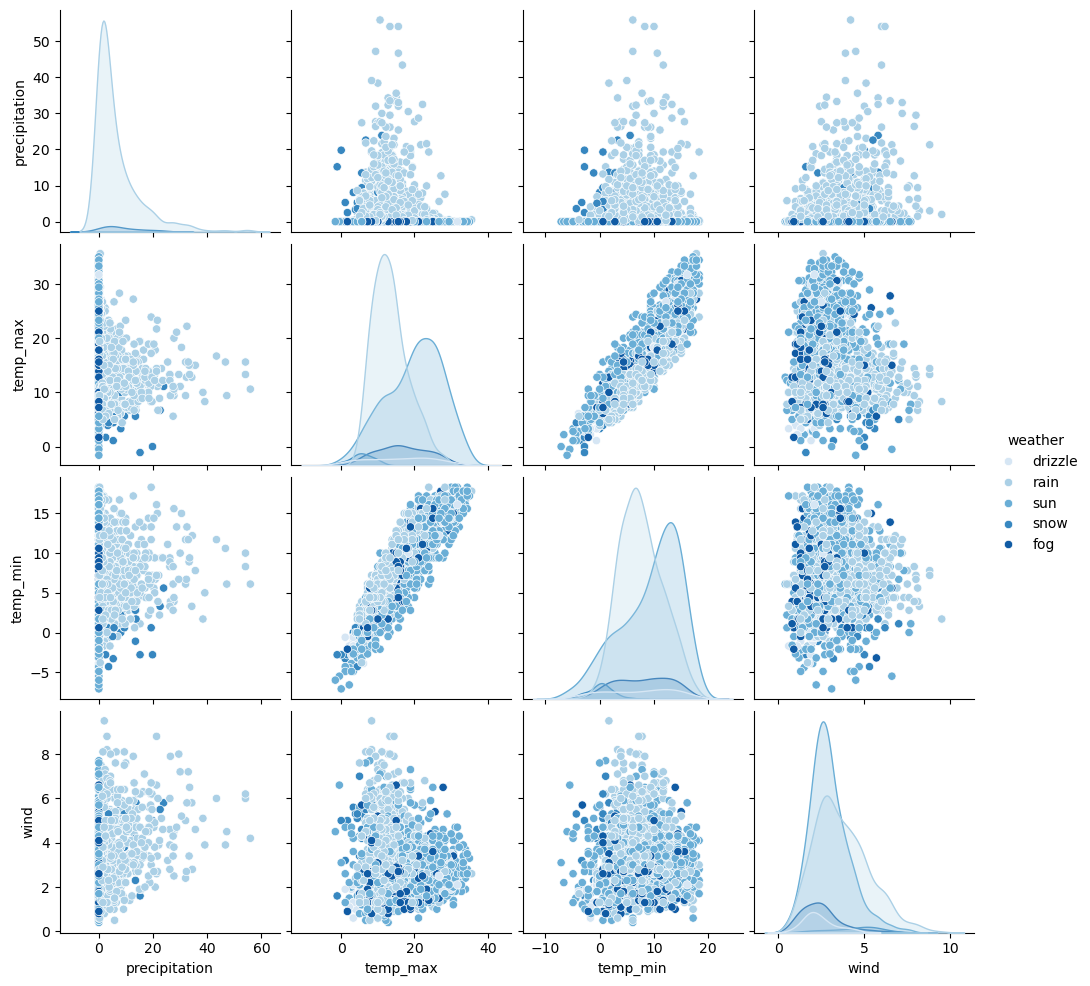

In [6]:
sns.pairplot(data = df, hue="weather", palette="Blues");

## Chuẩn hóa dữ liệu

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['weather'] = le.fit_transform(df['weather'])

## Chia tập dữ liệu

In [8]:
feature = ['precipitation', 'temp_max', 'temp_min', 'wind']
target = ['weather']
X = df[feature].values  
y = df[target].values.ravel()  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Xây dựng lớp Decision Tree

In [9]:
import numpy as np
from collections import Counter

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        if len(y.shape) > 1:
            y = y.ravel()
        
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
            
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)

        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])

    def _most_common_label(self, y):
        if len(y) == 0:
            return 0  
            
        counter = Counter(y)
        if not counter:
            return 0 
            
        most_common = counter.most_common(1)
        if not most_common:
            return 0 
            
        return most_common[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

## Xây dựng lớp Random Forest

In [10]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

## Huấn luyện mô hình

In [21]:
def accuracy(y_test, y_pred):
    # Đảm bảo cả hai đều là numpy array 1 chiều
    if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
        y_test = y_test.values.ravel()
    if isinstance(y_pred, pd.DataFrame) or isinstance(y_pred, pd.Series):
        y_pred = y_pred.values.ravel()
    
    accuracy = np.sum(y_test == y_pred) / len(y_test)
    return accuracy

clf = RandomForest(n_trees=100)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

acc = accuracy(y_test, predictions)
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.8328


In [17]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier()
rdf.fit(X_train, y_train)
preds = rdf.predict(X_test)
acc_rd = accuracy(y_test, preds)
print(acc_rd)

0.8225255972696246


C:\Users\Admin\AppData\Local\Temp\ipykernel_15880\571413804.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Accuracy', data=models_comparison, palette=['#8884d8', '#82ca9d'])


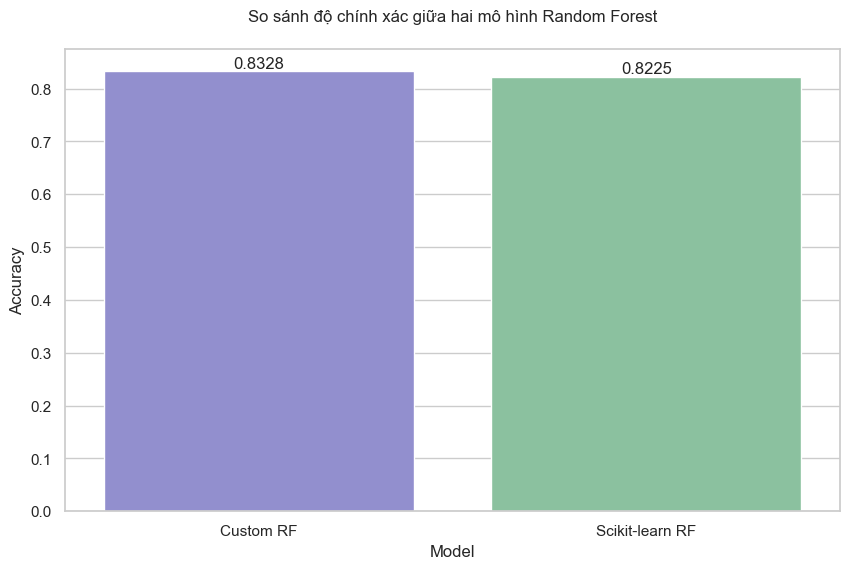

,Thông số,Custom RF,Scikit-learn RF
0,Số cây quyết định,100,100 (mặc định)
1,Thư viện,Custom,scikit-learn
2,Accuracy,0.8328,0.8225


In [24]:
# Tạo DataFrame cho việc so sánh
models_comparison = pd.DataFrame({
    'Model': ['Custom RF', 'Scikit-learn RF'],
    'Accuracy': [acc, acc_rd]
})

# Thiết lập style cho đồ thị - bỏ qua plt.style.use('seaborn')
plt.figure(figsize=(10, 6))

# Sử dụng sns.set_theme() thay thế
sns.set_theme(style="whitegrid")

# Vẽ biểu đồ cột
ax = sns.barplot(x='Model', y='Accuracy', data=models_comparison, palette=['#8884d8', '#82ca9d'])

# Tùy chỉnh đồ thị
plt.title('So sánh độ chính xác giữa hai mô hình Random Forest', pad=20)
plt.ylabel('Accuracy')

# Thêm giá trị accuracy lên đầu mỗi cột
for i, v in enumerate(models_comparison['Accuracy']):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')

# Hiển thị đồ thị
plt.show()

# In bảng so sánh chi tiết
comparison_table = pd.DataFrame({
    'Thông số': ['Số cây quyết định', 'Thư viện', 'Accuracy'],
    'Custom RF': ['100', 'Custom', f'{acc:.4f}'],
    'Scikit-learn RF': ['100 (mặc định)', 'scikit-learn', f'{acc_rd:.4f}']
})

# Hiển thị bảng so sánh
display(comparison_table)